In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
x = np.arange(100, 2500, 100)
job0 = np.arange(0, 1200, 24)
jobs = list()

for i in range(len(job0)):
    jobs.append(job0)
    job0 = job0 +1

In [4]:
columnnames = ['y_exit', 'z_exit', 'x_start', 'y_start', 'z_start', 'px_start', 'py_start', 'pz_start', 'reflCoCl', 'reflClCl', 'wl','gpsPosX', 'length_core', 'length_clad', 'rayleighScatterings']

daten = pd.DataFrame()

for i in range(0,1199):
    df_i = pd.read_csv('../data/Simulation/job_{}.txt'.format(i), sep='\t', skiprows=1, names = columnnames)
    for j in range(len(jobs)):
        if np.isin(i, jobs[j]) == np.array(True):
            df_i['x'] = x[j]
            break
    daten = pd.concat([daten, df_i])
daten.to_hdf('../data/data.hdf5', key='Daten')


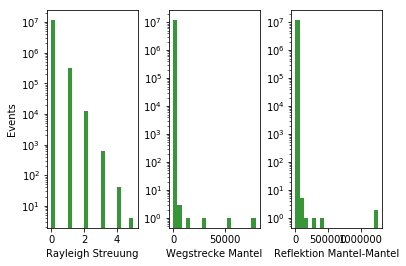

In [5]:
#Daten einlesen
daten = pd.read_hdf('../data/data.hdf5', key='Daten')

# ----Histogramm der Schnittvariablen----
plt.subplot(1,3,1)
plt.hist(daten['rayleighScatterings'], bins = 20, color = 'forestgreen', alpha=0.9)
plt.xlabel(r'Rayleigh Streuung')
plt.ylabel(r'Events')
plt.yscale('log')
plt.subplot(1,3,2)
plt.hist(daten['length_clad'], bins = 20, color = 'forestgreen', alpha=0.9)
plt.xlabel(r'Wegstrecke Mantel')
#plt.ylabel(r'Events')
plt.yscale('log')
plt.subplot(1,3,3)
plt.hist(daten['reflClCl'], bins = 20, color = 'forestgreen', alpha=0.9)
plt.xlabel(r'Reflektion Mantel-Mantel')
#plt.ylabel(r'Events')
plt.yscale('log')

plt.subplots_adjust(wspace = 0.35)
plt.savefig('../plots/cuts_sim.pdf')

In [6]:
#-----Selektion---------
#Rayleigh
daten = daten.loc[daten['rayleighScatterings']==0]

#Kern
data = daten.loc[daten['length_clad']==0]
data = data.loc[data['reflClCl']==0]
data.head(10)

#Mantel
data_clad = daten.loc[daten['length_clad']>0]


The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


/home/miriam/.local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


häufigster Winkel Mantel: 26.793710211877528
häufigster Winkel Kern: 20.291326075439944


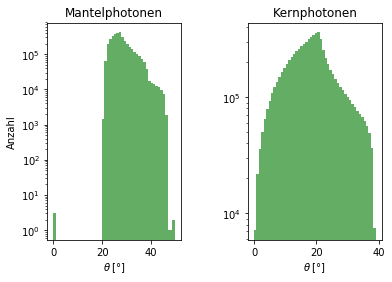

In [7]:
#------Theta berechnen und histogrammieren (für Mantel und Kern)----
data['theta']= np.arccos(data['px_start'])
data_clad['theta']= np.arccos(data_clad['px_start'])

plt.subplot(1,2,1)
array_m, bins_m, patches_m = plt.hist(data_clad['theta']*(360/2/np.pi), bins = 50, color ='forestgreen', alpha = 0.7)
plt.title(r'Mantelphotonen')
plt.xlabel(r'$\theta\;$[°]')
plt.ylabel(r'Anzahl')
plt.yscale('log')

plt.subplot(1,2,2)
array_c, bins_c, patches_c = plt.hist(data['theta']*(360/2/np.pi), bins = 50, color = 'forestgreen', alpha = 0.7)
plt.title(r'Kernphotonen')
plt.xlabel(r'$\theta\;$[°]')
plt.yscale('log')

plt.subplots_adjust(wspace = 0.5)
plt.savefig('../plots/theta_sim.pdf')

#Winkel_Mantel = array_m[np.argmax(bins_m)]
#print(Winkel_Mantel)
Haeuf_Winkel_m = bins_m[np.argmax(array_m)]
Haeuf_Winkel_k = bins_c[np.argmax(array_c)]
print('häufigster Winkel Mantel:', Haeuf_Winkel_m)
print('häufigster Winkel Kern:', Haeuf_Winkel_k)


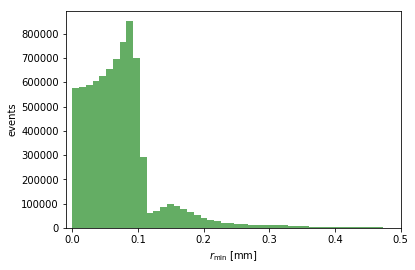

In [8]:
#----R_min berechnen und histogrammieren------
data['r_min'] = (np.abs(data['pz_start']*data['y_start']-data['py_start']*data['z_start']))/np.sqrt(data['pz_start']**2 + data['py_start']**2)
plt.hist(data['r_min'], color='forestgreen',alpha=0.7, bins=100)
plt.xlabel(r'$r_\mathrm{min}\;$[mm]')
plt.ylabel(r'events')
plt.xlim(-0.01, 0.5)
plt.savefig('../plots/rmin_sim.pdf')

In [9]:
#Zuschnitt auf r_min innerhalb des Kernes?
data = data.loc[data['r_min']<0.11]

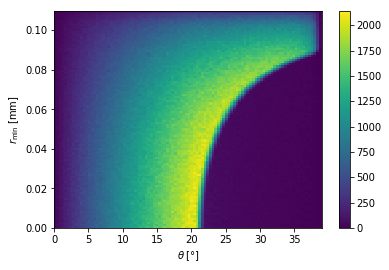

In [10]:
#---- Histogramm r_min, theta zur Mittelwertberechnung ---------
matrix_r, theta_r, r_min_r, image = plt.hist2d(data['theta']*(360/2/np.pi), data['r_min'], cmap='viridis', bins=100)
plt.ylabel(r'$r_\mathrm{min}\;$[mm]')
plt.xlabel(r'$\theta\;$[°]')
#plt.xscale('log')
#plt.yscale('log')
plt.colorbar()
plt.savefig('../plots/hist_rmin_sim.pdf')

In [11]:
#-----------Mittelwertberechnung von r_min pro Winkel--------
mean_r_min = []
for i in range(0,len(theta_r)-1):
    sum = 0.0
    ctr = 0.0
    for j in range(0,len(r_min_r)-1):
        sum += matrix_r[i,j]*r_min_r[j]
        ctr += matrix_r[i,j]
    mean_r_min.append(sum/ctr)
#mean_r_min

a 0.06505938668580791 0.00021798222906740553
b -6.541850235279417 0.1940980820073571
c 0.3585247262617634 0.009246115035904001


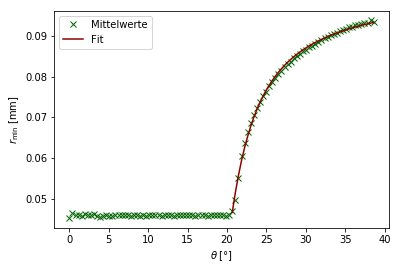

In [12]:
#---------Mittelwerte plotten-------
plt.plot(theta_r[:len(theta_r)-1], mean_r_min, color = 'darkgreen', linestyle='', marker ='x', label = r'Mittelwerte')
plt.ylabel(r'$r_\mathrm{min}\;$[mm]')
plt.xlabel(r'$\theta\;$[°]')

#--------Mittelwerte fitten----------
def fit(t, a, b, c):
    return a*np.arctan(b+c*t)

params, cov = curve_fit(fit, theta_r[53:len(theta_r)-1],  mean_r_min[53:],)
error = np.sqrt(np.diag(cov))

plt.plot(theta_r[53:len(theta_r)-1], fit(theta_r[53:len(theta_r)-1], *params), color = 'darkred', label =r'Fit')
plt.legend()
plt.savefig('../plots/rmin_mean_sim.pdf')
print('a', params[0], error[0])
print('b', params[1], error[1])
print('c', params[2], error[2])
#print('d', params[3], error[3])

In [13]:
print(theta_r[:len(theta_r)-1][0])
mean_r_min[0]

0.0


0.0452164576643557

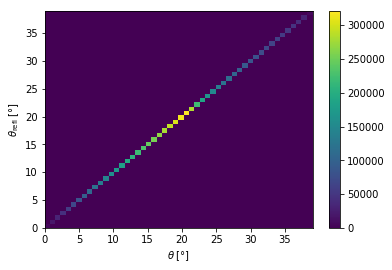

In [14]:
#---------Berechnung theta_refl----------
r_Kern = 110 #Mikrometer
data['theta_refl'] = np.arcsin(np.sqrt(1-((data['r_min']**2)/(r_Kern**2)))*np.sin(data['theta']))

#--------Histogramm zur Mittelwertberechnung von theta_refl pro Winkel-------------
matrix, theta, theta_refl, image = plt.hist2d(data['theta']*(360/2/np.pi), data['theta_refl']*(360/2/np.pi),cmap='viridis', bins=50)
plt.ylabel(r'$\theta_\mathrm{refl}\;$[°]')
plt.xlabel(r'$\theta\;$[°]')
#plt.xscale('log')
#plt.yscale('log')
plt.colorbar()
plt.savefig('../plots/Theta_refl_sim.pdf')

In [15]:
#-------Mittelwertberechnung von theta_refl pro Winkel--------
mean_theta_refl = []
for i in range(0,len(theta)-1):
    sum = 0.0
    ctr = 0.0
    for j in range(0,len(theta_refl)-1):
        sum += matrix[i,j]*theta_refl[j]
        ctr += matrix[i,j]
    mean_theta_refl.append(sum/ctr)


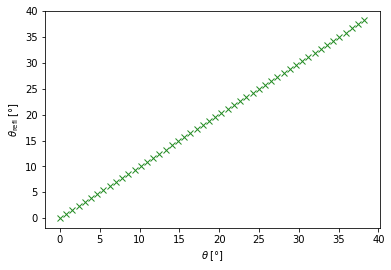

In [16]:
#-------Mittelwerte plotten----------
plt.plot(theta[:len(theta)-1], mean_theta_refl, color = 'forestgreen', linestyle='', marker ='x')
plt.ylabel(r'$\theta_\mathrm{refl}\;$[°]')
plt.xlabel(r'$\theta\;$[°]')
plt.savefig('../plots/Theta_refl_mean_sim.pdf')

In [17]:
#-----Verhältniss Mantelphotonen zu Kernphotonen pro Winkel----
ratio = [] 
for i in range(0, len(bins_c)-1):
    ratio.append(array_m[i]/array_c[i])



In [18]:
#----------------Größte Winkel mit nur Kernphotonen------------
#Nur Kernphotonen -> # Mantelphotonen = 0 -> Ratio = 0
theta_just_core = []
y = [] #Zum plotten
for i in range(0, len(ratio)-1):
    if ratio[i] == 0:
        theta_just_core.append(bins_c[i])
        y.append(0)
        
theta_just_core_max = np.max(theta_just_core)
print(theta_just_core_max)


14.828276747436883


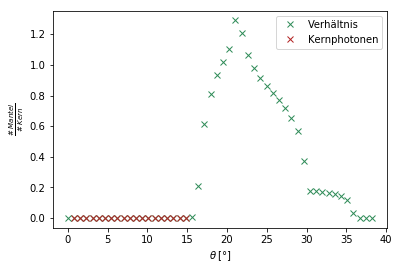

In [19]:
#---Verhältnis und Kernphotonen plotten-------
plt.plot(bins_c[:len(bins_c)-1], ratio, marker = 'x', linestyle = '', color = 'seagreen', label = r'Verhältnis')
plt.plot(theta_just_core, y, marker = 'x', linestyle = '', color = 'firebrick', label = r'Kernphotonen')
plt.xlabel(r'$\theta\;$[°]')
plt.ylabel(r'$\frac{\# \; Mantel}{\# \; Kern}$')
plt.legend()
plt.savefig('../plots/ratio_sim.pdf')

In [20]:
#------Größter Winkel unter dem noch Photonen auftreten in Abhängigkeit von r_min-----
#Nutze Histogramm zur Mittelwertbestimmung von r_min
r_min_max = []
theta_max = []
for i in range(0, len(r_min_r)-1):
    for j in range(0, len(theta_r)-1):
        if matrix_r[i,j] <130:
            theta_max.append(theta_r[j-1])
            r_min_max.append(r_min_r[i])
            break

In [21]:
#------ Plot der maximalen Winkel in Abhängigkeit von r_min----------
#plt.plot(r_min_max, theta_max, color = 'forestgreen', marker = 'x', linestyle = '')
#plt.xlabel(r'$r_\mathrm{min}\;$[mm]')
#plt.ylabel(r'$\theta_\mathrm{max}\;$[°]')
#plt.savefig('../plots/theta_max_sim.pdf')

0.08799983204140983


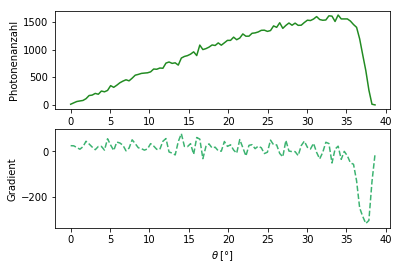

In [22]:
#theta_r, r_min_r, matrix_r
plt.subplot(2,1,1)
plt.plot(theta_r[0:-1],matrix_r[:,80], color = 'forestgreen')
plt.ylabel(r'Photonenanzahl')

plt.subplot(2,1,2)
plt.plot(theta_r[0:-1],np.gradient(matrix_r[:,80]), color = 'mediumseagreen', linestyle = '--')
plt.xlabel(r'$\theta\;$[°]')
plt.ylabel(r'Gradient')

plt.savefig('../plots/theta_max_grad_bsp.pdf')
print(r_min_r[80])

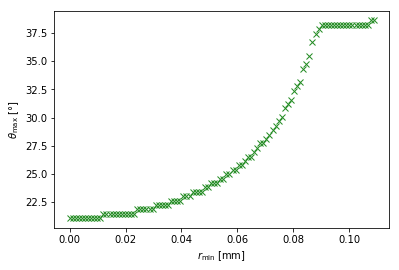

In [23]:
#Es wird Stelle gesucht, wo rapider Abfall zu Ende ist
# -> Maximum der dritten Ableitung 
sec_grad_max = []
for i in range(len(matrix_r)):
    sec_grad_max.append(theta_r[(np.argmin((np.gradient((matrix_r[:,i])))))])

plt.plot(r_min_r[0:-1], sec_grad_max, color = 'forestgreen', marker = 'x', linestyle = '')
#plt.hlines(38, 0.06,0.1)
plt.xlabel(r'$r_\mathrm{min}\;$[mm]')
plt.ylabel(r'$\theta_\mathrm{max}\;$[°]')
plt.savefig('../plots/theta_max_sim.pdf')

Austrittswinkel alpha (Zum Vergleich mit Messwerten)(Punkt 5)

In [24]:
data['Austrittswinkel'] = np.arcsin(np.sin(data['theta'])*(1.6/3.882))
data_clad['Austrittswinkel'] = np.arcsin(np.sin(data_clad['theta'])*(1.6/3.882))
#arcsin returns radiant

/home/miriam/.local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


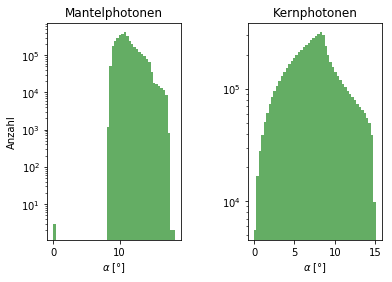

In [25]:
plt.subplot(1,2,1)
plt.hist(data_clad['Austrittswinkel']*(360/2/np.pi), bins = 50, color ='forestgreen', alpha = 0.7)
plt.title(r'Mantelphotonen')
plt.xlabel(r'$\alpha\;$[°]')
plt.ylabel(r'Anzahl')
plt.yscale('log')

plt.subplot(1,2,2)
plt.hist(data['Austrittswinkel']*(360/2/np.pi), bins = 50, color = 'forestgreen', alpha = 0.7)
plt.title(r'Kernphotonen')
plt.xlabel(r'$\alpha\;$[°]')
plt.yscale('log')

plt.subplots_adjust(wspace = 0.5)
plt.savefig('../plots/austritt_simu.pdf')

Winkelabhängige Abschwächung (Zum Vergleich mit Messdaten)(Punkt 6)

In [26]:
data.head()

,y_exit,z_exit,x_start,y_start,z_start,px_start,py_start,pz_start,reflCoCl,reflClCl,wl,gpsPosX,length_core,length_clad,rayleighScatterings,x,theta,r_min,theta_refl,Austrittswinkel
0,-0.026978,-0.061619,2400.019897,-0.051878,0.096635,0.948434,0.162628,-0.272077,3649.0,0.0,472.743103,2400.0,2530.557861,0.0,0.0,100,0.322539,0.005049,0.322539,0.131019
1,-0.055254,0.050902,2400.000732,0.085666,0.015889,0.977825,-0.139056,-0.156593,2674.0,0.0,504.521210,2400.0,2454.456055,0.0,0.0,100,0.210985,0.053506,0.210985,0.086423
4,0.050591,0.043467,2400.000977,-0.004035,-0.069628,0.971248,-0.103995,-0.214154,2757.0,0.0,489.916565,2400.0,2470.986084,0.0,0.0,100,0.240377,0.026786,0.240377,0.098280
5,0.016537,0.030342,2487.261475,0.037348,0.037756,0.947609,0.023118,0.318594,4014.0,0.0,527.115417,2400.0,2624.865234,0.0,0.0,100,0.325130,0.034518,0.325130,0.132040
6,0.074679,-0.021847,2400.000244,0.095372,0.006802,0.933133,-0.234433,-0.272586,5341.0,0.0,483.546570,2400.0,2571.967773,0.0,0.0,100,0.367764,0.067873,0.367764,0.148731


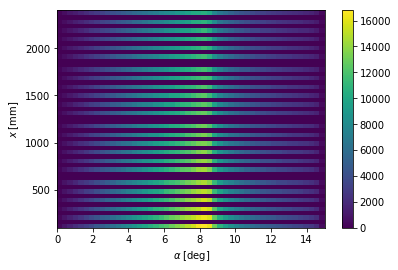

In [92]:
matrix_alpha, alpha_hist, x_hist, _ = plt.hist2d(data['Austrittswinkel']*(360/2/np.pi), data['gpsPosX'],cmap='viridis', bins=50)
plt.xlabel(r'$\alpha\;$[deg]')
plt.ylabel(r'$x\;$[mm]')
plt.colorbar()

In [93]:
#Fitfunktion
def fit_exp(x,a,b):
    return a*np.exp(-b*x)

286.19754025192805


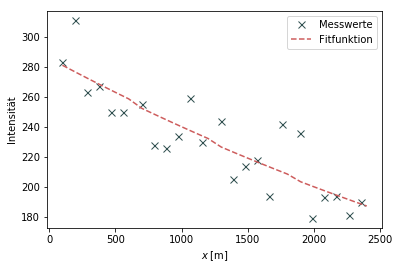

In [94]:
a=np.where(matrix_alpha[0]!=0)
plt.plot(x_hist[a], matrix_alpha[0,a][0], color = 'darkslategrey', marker = 'x', linestyle='', label = 'Messwerte', markersize = 7)

params, cov = curve_fit(fit_exp, x_hist[a], matrix_alpha[0,a][0], (300,0.001))
error = np.sqrt(np.diag(cov))

y = list()
for i in range(len(x_hist[a])):
    y.append(fit_exp(x_hist[a][i], *params))

plt.plot(x, y, color = 'indianred', linestyle = '--', label = 'Fitfunktion')

plt.xlabel(r'$x\;$[m]')
plt.ylabel(r'Intensität')
plt.legend()

plt.savefig('fit_exp_simu_bsp.pdf', )

In [95]:
fit_exp_a = list() 
fit_exp_b = list()
fit_exp_a_err = list() 
fit_exp_b_err = list()

for i in range(len(alpha_hist)-2):
    a=np.where(matrix_alpha[i]!=0)
    
    params, cov = curve_fit(fit_exp, x_hist[a], matrix_alpha[i,a][0], (300,0.001))
    error = np.sqrt(np.diag(cov))

    fit_exp_a.append(params[0])
    fit_exp_b.append(params[1])
    fit_exp_a_err.append(error[0])
    fit_exp_b_err.append(error[1])

In [96]:
(np.array(fit_exp_b))

array([0.00018064, 0.00020613, 0.00020278, 0.00019435, 0.00019962,
       0.00019514, 0.00018705, 0.00019676, 0.00019142, 0.00019621,
       0.00018603, 0.00018741, 0.00019633, 0.00019519, 0.00018911,
       0.00019382, 0.00019107, 0.00019685, 0.0001949 , 0.00019187,
       0.00019692, 0.00019712, 0.00019689, 0.00019413, 0.00019964,
       0.00019268, 0.00020205, 0.00019804, 0.0002153 , 0.00022118,
       0.00022101, 0.00021114, 0.00020934, 0.00021699, 0.00021659,
       0.00020454, 0.00021373, 0.0002149 , 0.00020591, 0.0002106 ,
       0.00022469, 0.00021841, 0.00022415, 0.00022568, 0.00022377,
       0.0002246 , 0.00021531, 0.00023293, 0.00021901])

Text(0, 0.5, 'Abschwächung$\\;$[m$^{-1}$]')

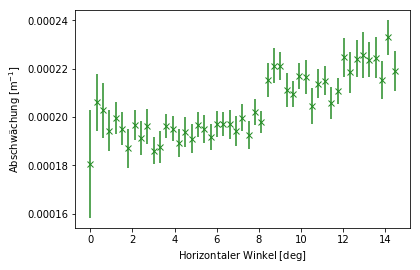

In [97]:
plt.errorbar(alpha_hist[:-2], np.array(fit_exp_b), yerr=np.array(fit_exp_b_err), fmt='x', color = 'forestgreen')
plt.xlabel(r'Horizontaler Winkel$\;$[deg]')
plt.ylabel(r'Abschwächung$\;$[m$^{-1}$]')